# OpenAI API Test Notebook

## Count and sample from labeled dataset

In [2]:
import json
import random
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import base64
from openai import OpenAI
from dotenv import load_dotenv
from tqdm import tqdm
import re

In [3]:
HAND_LABELED_PATH = "../hand_labeled_annotations.json"
SAMPLED_OUT_PATH = "../sample_100_for_openai.json"

with open(HAND_LABELED_PATH) as f:
    data = json.load(f)

combo_counts = Counter((d["turn_signal"], d["tail_light"]) for d in data)
print("Class distribution:")
for combo, count in combo_counts.items():
    print(f"{combo}: {count}")

Class distribution:
('none', 'off'): 7994
('none', 'on'): 1617
('none', 'not_visible'): 229
('right', 'off'): 52
('left', 'off'): 69
('left', 'on'): 17
('right', 'on'): 22


In [5]:
sampling_scheme = {
    ("none", "off"): 25,
    ("none", "on"): 25,
    ("left", "on"): 10,
    ("left", "off"): 10,
    ("right", "off"): 10,
    ("right", "on"): 10,
    ("none", "not_visible"): 10
}

In [6]:
# sampled = []
# for combo, n in sampling_scheme.items():
#     subset = [d for d in data if (d["turn_signal"], d["tail_light"]) == combo]
#     if len(subset) < n:
#         print(f"Only found {len(subset)} samples for {combo}, taking all available.")
#     sampled.extend(random.sample(subset, min(len(subset), n)))

# print(f"\nTotal sampled: {len(sampled)}")
# with open(SAMPLED_OUT_PATH, "w") as f:
#     json.dump(sampled, f, indent=2)
# print(f"Saved sampled subset to {SAMPLED_OUT_PATH}")


Total sampled: 100
Saved sampled subset to ../sample_100_for_openai.json


## Run the OpenAI API on the sampled images

In [4]:
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

SAMPLED_PATH = "../sample_100_for_openai.json"
OUTPUT_FILE = "openai_light_predictions.json"
LOCAL_BASE = "../sampled_images" 

In [5]:
def encode_image(image_path):
    with open(image_path, "rb") as img:
        return base64.b64encode(img.read()).decode("utf-8")

In [6]:
def classify_image(local_path):
    img_b64 = encode_image(local_path)
    prompt = {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": (
                    "You are an image analysis model. Look at the car image and determine:\n"
                    "1. turn_signal — one of: left, right, none, both\n"
                    "2. tail_light — one of: on, off, not_visible\n\n"
                    "Return only valid JSON in this format:\n"
                    "{\n"
                    "  \"turn_signal\": \"left\",\n"
                    "  \"tail_light\": \"on\"\n"
                    "}"
                ),
            },
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img_b64}"}}
        ],
    }

    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[prompt],
            temperature=0,
            response_format={"type": "json_object"}, 
        )
        return json.loads(response.choices[0].message.content)
    except Exception as e:
        print(f"Error processing {local_path}: {e}")
        return {"turn_signal": "none", "tail_light": "not_visible"}

In [7]:
with open(SAMPLED_PATH) as f:
    sampled = json.load(f)

In [8]:
results = []
for entry in tqdm(sampled, desc="Classifying images"): # [0:2] to run through 2
    local_path = os.path.join(LOCAL_BASE, entry["image"].lstrip("/"))
    print(local_path)
    result = classify_image(local_path)
    results.append({
        "image": entry["image"],
        "hand_label": {
            "turn_signal": entry["turn_signal"],
            "tail_light": entry["tail_light"]
        },
        "openai_label": result
    })

with open(OUTPUT_FILE, "w") as f:
    json.dump(results, f, indent=2)

print(f"\nDone! Saved {len(results)} results to {OUTPUT_FILE}")

Classifying images:   0%|                               | 0/100 [00:00<?, ?it/s]

../sampled_images/gpfs/space/projects/ml2024/2024-08-16-16-12-55_mapping_tartu_streets/camera_wide_front/predict/crops/car/148476.jpg


Classifying images:   1%|▏                      | 1/100 [00:04<08:10,  4.95s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-08-16-13-00-58_mapping_tartu_streets/camera_narrow_front/predict/crops/car/033447.jpg


Classifying images:   2%|▍                      | 2/100 [00:06<04:23,  2.69s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-08-16-13-13-27_mapping_tartu_streets/camera_wide_front/predict/crops/car/039841.jpg


Classifying images:   3%|▋                      | 3/100 [00:08<03:56,  2.44s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-16-15-18-40_mapping_tartu_streets/camera_fl/predict/crops/car/056773.jpg


Classifying images:   4%|▉                      | 4/100 [00:10<03:57,  2.48s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-08-22-10-38-05_mapping_tartu_streets_bus_stops/camera_wide_right/predict/crops/car/0401199.jpg


Classifying images:   5%|█▏                     | 5/100 [00:12<03:15,  2.06s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-10-13-29-02_mapping_tartu_streets/camera_wide_left/predict/crops/car/0543884.jpg


Classifying images:   6%|█▍                     | 6/100 [00:13<02:52,  1.84s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-11-14-55-13_mapping_tartu_streets/camera_wide_left/predict/crops/car/040303.jpg


Classifying images:   7%|█▌                     | 7/100 [00:14<02:40,  1.73s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-11-15-39-14_mapping_tartu_streets/camera_narrow_front/predict/crops/car/0561303.jpg


Classifying images:   8%|█▊                     | 8/100 [00:16<02:21,  1.54s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-24-15-17-40_mapping_tartu_streets/camera_fl/predict/crops/car/008171.jpg


Classifying images:   9%|██                     | 9/100 [00:17<02:29,  1.64s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-08-12-01-14_mapping_tartu_streets/camera_wide_back/predict/crops/car/0104182.jpg


Classifying images:  10%|██▏                   | 10/100 [00:26<05:32,  3.69s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-16-13-05-46_mapping_tartu_streets/camera_narrow_front/predict/crops/car/0081734.jpg


Classifying images:  11%|██▍                   | 11/100 [00:27<04:18,  2.90s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-10-13-02-50_mapping_tartu_streets/camera_narrow_front/predict/crops/car/036550.jpg


Classifying images:  12%|██▋                   | 12/100 [00:30<04:31,  3.08s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-09-05-14-18-54_mapping_tartu_streets_traffic_lights_ouster_lidar_2/camera_narrow_front/predict/crops/car/003212.jpg


Classifying images:  13%|██▊                   | 13/100 [00:32<03:39,  2.52s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-11-15-51-59_mapping_tartu_streets/camera_wide_front/predict/crops/car/0728183.jpg


Classifying images:  14%|███                   | 14/100 [00:33<03:07,  2.18s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-08-13-58-31_mapping_tartu_streets/camera_narrow_front/predict/crops/car/0762262.jpg


Classifying images:  15%|███▎                  | 15/100 [00:34<02:47,  1.97s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-09-05-13-41-48_mapping_tartu_streets_traffic_lights_ouster_lidar/camera_narrow_front/predict/crops/car/0148094.jpg


Classifying images:  16%|███▌                  | 16/100 [00:35<02:21,  1.69s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-11-15-39-14_mapping_tartu_streets/camera_wide_left/predict/crops/car/0561292.jpg


Classifying images:  17%|███▋                  | 17/100 [00:36<02:02,  1.48s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-16-14-46-34_mapping_tartu_streets/camera_fl/predict/crops/car/043864.jpg


Classifying images:  18%|███▉                  | 18/100 [00:38<01:52,  1.38s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-09-05-13-41-48_mapping_tartu_streets_traffic_lights_ouster_lidar/camera_narrow_front/predict/crops/car/0153203.jpg


Classifying images:  19%|████▏                 | 19/100 [00:39<01:49,  1.35s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-08-15-57-58_mapping_tartu_streets/camera_fl/predict/crops/car/025719.jpg


Classifying images:  20%|████▍                 | 20/100 [00:40<01:43,  1.30s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-10-16-29-05_mapping_tartu_streets/camera_fl/predict/crops/car/0417826.jpg


Classifying images:  21%|████▌                 | 21/100 [00:41<01:33,  1.18s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-24-16-06-06_mapping_tartu_streets/camera_fl/predict/crops/car/006555.jpg


Classifying images:  22%|████▊                 | 22/100 [00:44<02:05,  1.60s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-08-12-01-14_mapping_tartu_streets/camera_wide_front/predict/crops/car/007911.jpg


Classifying images:  23%|█████                 | 23/100 [00:45<01:56,  1.51s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-09-05-14-18-54_mapping_tartu_streets_traffic_lights_ouster_lidar_2/camera_narrow_front/predict/crops/car/0054964.jpg


Classifying images:  24%|█████▎                | 24/100 [00:47<01:58,  1.56s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-12-15-36-02_mapping_tartu_streets/camera_fl/predict/crops/car/0516452.jpg


Classifying images:  25%|█████▌                | 25/100 [00:48<01:53,  1.52s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-16-14-21-41_mapping_tartu_streets/camera_narrow_front/predict/crops/car/053789.jpg


Classifying images:  26%|█████▋                | 26/100 [00:49<01:42,  1.38s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-18-14-25-15_mapping_tartu_streets/camera_fl/predict/crops/car/0027764.jpg


Classifying images:  27%|█████▉                | 27/100 [00:50<01:29,  1.22s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-12-16-13-33_mapping_tartu_streets/camera_fl/predict/crops/car/0736153.jpg


Classifying images:  28%|██████▏               | 28/100 [00:52<01:44,  1.44s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-08-15-08-55_mapping_tartu_streets/camera_fl/predict/crops/car/0054673.jpg


Classifying images:  29%|██████▍               | 29/100 [00:53<01:31,  1.29s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-16-13-05-46_mapping_tartu_streets/camera_narrow_front/predict/crops/car/0076082.jpg


Classifying images:  30%|██████▌               | 30/100 [01:03<04:41,  4.02s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-08-12-15-50_mapping_tartu_streets/camera_wide_right/predict/crops/car/022993.jpg


Classifying images:  31%|██████▊               | 31/100 [01:04<03:37,  3.15s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-09-05-14-18-54_mapping_tartu_streets_traffic_lights_ouster_lidar_2/camera_wide_left/predict/crops/car/0029422.jpg


Classifying images:  32%|███████               | 32/100 [01:05<02:54,  2.57s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-08-12-55-12_mapping_tartu_streets/camera_wide_front/predict/crops/car/038820.jpg


Classifying images:  33%|███████▎              | 33/100 [01:06<02:19,  2.07s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-08-22-10-31-21_mapping_tartu_streets_bus_stops/camera_wide_front/predict/crops/car/0287412.jpg


Classifying images:  34%|███████▍              | 34/100 [01:07<01:55,  1.75s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-08-12-01-14_mapping_tartu_streets/camera_wide_front/predict/crops/car/0092332.jpg


Classifying images:  35%|███████▋              | 35/100 [01:08<01:39,  1.53s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-16-14-46-34_mapping_tartu_streets/camera_fl/predict/crops/car/0434503.jpg


Classifying images:  36%|███████▉              | 36/100 [01:09<01:25,  1.33s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-16-14-06-42_mapping_tartu_streets/camera_wide_front/predict/crops/car/0424843.jpg


Classifying images:  37%|████████▏             | 37/100 [01:10<01:18,  1.25s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-08-22-09-53-47_mapping_tartu_streets_bus_stops/camera_narrow_front/predict/crops/car/0045682.jpg


Classifying images:  38%|████████▎             | 38/100 [01:12<01:19,  1.28s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-11-15-51-59_mapping_tartu_streets/camera_narrow_front/predict/crops/car/060056.jpg


Classifying images:  39%|████████▌             | 39/100 [01:13<01:20,  1.32s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-09-16-31-06_mapping_tartu_streets/camera_fl/predict/crops/car/024235.jpg


Classifying images:  40%|████████▊             | 40/100 [01:14<01:14,  1.25s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-10-14-56-41_mapping_tartu_streets/camera_wide_front/predict/crops/car/111558.jpg


Classifying images:  41%|█████████             | 41/100 [01:25<03:57,  4.03s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-08-17-05-18_mapping_tartu_streets/camera_fl/predict/crops/car/007540.jpg


Classifying images:  42%|█████████▏            | 42/100 [01:26<03:08,  3.25s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-16-14-35-13_mapping_tartu_streets/camera_narrow_front/predict/crops/car/0594513.jpg


Classifying images:  43%|█████████▍            | 43/100 [01:27<02:27,  2.58s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-09-15-34-13_mapping_tartu_streets/camera_narrow_front/predict/crops/car/0213113.jpg


Classifying images:  44%|█████████▋            | 44/100 [01:29<02:05,  2.23s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-06-14-16-26-39_testing_nvidia_cam_driver_h264_encoding_for_mapping/camera_wide_back/predict/crops/car/016078.jpg


Classifying images:  45%|█████████▉            | 45/100 [01:30<01:41,  1.85s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-09-05-13-41-48_mapping_tartu_streets_traffic_lights_ouster_lidar/camera_wide_front/predict/crops/car/0206644.jpg


Classifying images:  46%|██████████            | 46/100 [01:31<01:25,  1.58s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-11-14-32-54_mapping_tartu_streets/camera_wide_front/predict/crops/car/0119804.jpg


Classifying images:  47%|██████████▎           | 47/100 [01:32<01:22,  1.55s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-08-14-19-07_mapping_tartu_streets/camera_wide_front/predict/crops/car/0897502.jpg


Classifying images:  48%|██████████▌           | 48/100 [01:35<01:44,  2.00s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-16-15-06-03_mapping_tartu_streets/camera_fl/predict/crops/car/047825.jpg


Classifying images:  49%|██████████▊           | 49/100 [01:36<01:28,  1.74s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-08-17-05-18_mapping_tartu_streets/camera_fl/predict/crops/car/007703.jpg


Classifying images:  50%|███████████           | 50/100 [01:37<01:16,  1.53s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-08-16-14-33-25_mapping_tartu_streets/camera_narrow_front/predict/crops/car/087911.jpg


Classifying images:  51%|███████████▏          | 51/100 [01:38<01:09,  1.41s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-12-16-02-09_mapping_tartu_streets/camera_fl/predict/crops/car/068958.jpg


Classifying images:  52%|███████████▍          | 52/100 [01:49<03:17,  4.12s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-08-16-16-03-30_mapping_tartu_streets/camera_wide_front/predict/crops/car/143017.jpg


Classifying images:  53%|███████████▋          | 53/100 [01:51<02:45,  3.51s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-16-13-39-36_mapping_tartu_streets/camera_wide_front/predict/crops/car/0289392.jpg


Classifying images:  54%|███████████▉          | 54/100 [01:52<02:10,  2.85s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-08-15-04-47_mapping_tartu_streets/camera_fl/predict/crops/car/0041512.jpg


Classifying images:  55%|████████████          | 55/100 [01:53<01:47,  2.39s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-08-16-16-03-30_mapping_tartu_streets/camera_wide_front/predict/crops/car/142863.jpg


Classifying images:  56%|████████████▎         | 56/100 [01:55<01:31,  2.07s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-10-13-02-50_mapping_tartu_streets/camera_narrow_front/predict/crops/car/036552.jpg


Classifying images:  57%|████████████▌         | 57/100 [01:56<01:15,  1.76s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-08-12-15-50_mapping_tartu_streets/camera_narrow_front/predict/crops/car/0187522.jpg


Classifying images:  58%|████████████▊         | 58/100 [01:57<01:06,  1.59s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-18-14-25-15_mapping_tartu_streets/camera_fl/predict/crops/car/0004912.jpg


Classifying images:  59%|████████████▉         | 59/100 [01:59<01:04,  1.58s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-12-14-09-54_mapping_tartu_streets/camera_fl/predict/crops/car/012056.jpg


Classifying images:  60%|█████████████▏        | 60/100 [02:00<00:57,  1.45s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-10-14-36-59_mapping_tartu_streets/camera_wide_back/predict/crops/car/0998002.jpg


Classifying images:  61%|█████████████▍        | 61/100 [02:02<01:06,  1.72s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-08-14-24-35_mapping_tartu_streets/camera_wide_front/predict/crops/car/0929172.jpg


Classifying images:  62%|█████████████▋        | 62/100 [02:03<01:01,  1.61s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-16-14-21-41_mapping_tartu_streets/camera_wide_front/predict/crops/car/055117.jpg


Classifying images:  63%|█████████████▊        | 63/100 [02:05<00:58,  1.58s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-10-13-29-02_mapping_tartu_streets/camera_narrow_front/predict/crops/car/0548522.jpg


Classifying images:  64%|██████████████        | 64/100 [02:06<00:49,  1.38s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-10-12-17-08_mapping_tartu_streets/camera_wide_back/predict/crops/car/009482.jpg


Classifying images:  65%|██████████████▎       | 65/100 [02:07<00:45,  1.31s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-08-12-01-14_mapping_tartu_streets/camera_wide_front/predict/crops/car/0061424.jpg


Classifying images:  66%|██████████████▌       | 66/100 [02:09<00:46,  1.37s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-16-14-47-30_mapping_tartu_streets/camera_narrow_front/predict/crops/car/068277.jpg


Classifying images:  67%|██████████████▋       | 67/100 [02:10<00:46,  1.41s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-16-14-47-30_mapping_tartu_streets/camera_wide_front/predict/crops/car/0681983.jpg


Classifying images:  68%|██████████████▉       | 68/100 [02:11<00:42,  1.34s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-06-14-16-26-39_testing_nvidia_cam_driver_h264_encoding_for_mapping/camera_wide_right/predict/crops/car/018138.jpg


Classifying images:  69%|███████████████▏      | 69/100 [02:12<00:37,  1.22s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-08-16-14-54-43_mapping_tartu_streets/camera_wide_back/predict/crops/car/1012224.jpg


Classifying images:  70%|███████████████▍      | 70/100 [02:14<00:38,  1.28s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-08-22-09-53-47_mapping_tartu_streets_bus_stops/camera_wide_front/predict/crops/car/0245093.jpg


Classifying images:  71%|███████████████▌      | 71/100 [02:15<00:34,  1.21s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-12-16-13-33_mapping_tartu_streets/camera_fl/predict/crops/car/0713964.jpg


Classifying images:  72%|███████████████▊      | 72/100 [02:16<00:34,  1.24s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-11-15-51-59_mapping_tartu_streets/camera_wide_front/predict/crops/car/074515.jpg


Classifying images:  73%|████████████████      | 73/100 [02:17<00:31,  1.15s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-24-15-17-40_mapping_tartu_streets/camera_fl/predict/crops/car/002217.jpg


Classifying images:  74%|████████████████▎     | 74/100 [02:18<00:29,  1.14s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-09-05-13-41-48_mapping_tartu_streets_traffic_lights_ouster_lidar/camera_wide_front/predict/crops/car/016189.jpg


Classifying images:  75%|████████████████▌     | 75/100 [02:20<00:32,  1.29s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-08-13-58-31_mapping_tartu_streets/camera_narrow_front/predict/crops/car/084773.jpg


Classifying images:  76%|████████████████▋     | 76/100 [02:21<00:31,  1.30s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-08-22-09-53-47_mapping_tartu_streets_bus_stops/camera_narrow_front/predict/crops/car/0182613.jpg


Classifying images:  77%|████████████████▉     | 77/100 [02:22<00:27,  1.20s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-08-22-10-38-05_mapping_tartu_streets_bus_stops/camera_wide_right/predict/crops/car/042902.jpg


Classifying images:  78%|█████████████████▏    | 78/100 [02:23<00:26,  1.23s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-11-14-55-13_mapping_tartu_streets/camera_wide_back/predict/crops/car/0363942.jpg


Classifying images:  79%|█████████████████▍    | 79/100 [02:34<01:23,  3.97s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-09-05-13-41-48_mapping_tartu_streets_traffic_lights_ouster_lidar/camera_narrow_front/predict/crops/car/016402.jpg


Classifying images:  80%|█████████████████▌    | 80/100 [02:35<01:04,  3.23s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-11-15-39-14_mapping_tartu_streets/camera_narrow_front/predict/crops/car/0555742.jpg


Classifying images:  81%|█████████████████▊    | 81/100 [02:38<00:57,  3.01s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-16-15-06-03_mapping_tartu_streets/camera_fl/predict/crops/car/0481342.jpg


Classifying images:  82%|██████████████████    | 82/100 [02:39<00:43,  2.41s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-12-14-03-44_mapping_tartu_streets/camera_fl/predict/crops/car/00640512.jpg


Classifying images:  83%|██████████████████▎   | 83/100 [02:40<00:34,  2.06s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-11-15-51-59_mapping_tartu_streets/camera_wide_front/predict/crops/car/074169.jpg


Classifying images:  84%|██████████████████▍   | 84/100 [02:41<00:28,  1.81s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-16-14-56-18_mapping_tartu_streets/camera_fl/predict/crops/car/045786.jpg


Classifying images:  85%|██████████████████▋   | 85/100 [02:42<00:24,  1.66s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-08-22-10-38-05_mapping_tartu_streets_bus_stops/camera_wide_front/predict/crops/car/0316302.jpg


Classifying images:  86%|██████████████████▉   | 86/100 [02:43<00:20,  1.47s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-18-14-49-13_mapping_tartu_streets/camera_fl/predict/crops/car/013955.jpg


Classifying images:  87%|███████████████████▏  | 87/100 [02:45<00:20,  1.61s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-16-14-56-18_mapping_tartu_streets/camera_fl/predict/crops/car/0457723.jpg


Classifying images:  88%|███████████████████▎  | 88/100 [02:47<00:18,  1.53s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-10-13-29-02_mapping_tartu_streets/camera_narrow_front/predict/crops/car/055477.jpg


Classifying images:  89%|███████████████████▌  | 89/100 [02:49<00:18,  1.66s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-08-22-09-53-47_mapping_tartu_streets_bus_stops/camera_narrow_front/predict/crops/car/023354.jpg


Classifying images:  90%|███████████████████▊  | 90/100 [02:50<00:14,  1.49s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-09-17-08-54_mapping_tartu_streets/camera_wide_front/predict/crops/car/0777388.jpg


Classifying images:  91%|████████████████████  | 91/100 [02:51<00:12,  1.37s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-08-12-15-50_mapping_tartu_streets/camera_wide_front/predict/crops/car/01589013.jpg


Classifying images:  92%|████████████████████▏ | 92/100 [02:52<00:11,  1.40s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-16-13-39-36_mapping_tartu_streets/camera_wide_back/predict/crops/car/0251584.jpg


Classifying images:  93%|████████████████████▍ | 93/100 [02:53<00:09,  1.35s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-16-13-48-42_mapping_tartu_streets/camera_wide_front/predict/crops/car/031540.jpg


Classifying images:  94%|████████████████████▋ | 94/100 [02:54<00:06,  1.16s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-08-13-58-31_mapping_tartu_streets/camera_wide_back/predict/crops/car/0829236.jpg


Classifying images:  95%|████████████████████▉ | 95/100 [02:55<00:05,  1.17s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-08-22-10-38-05_mapping_tartu_streets_bus_stops/camera_narrow_front/predict/crops/car/0319418.jpg


Classifying images:  96%|█████████████████████ | 96/100 [02:56<00:04,  1.12s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-11-15-51-59_mapping_tartu_streets/camera_wide_right/predict/crops/car/0802113.jpg


Classifying images:  97%|█████████████████████▎| 97/100 [02:58<00:03,  1.32s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-11-15-51-59_mapping_tartu_streets/camera_narrow_front/predict/crops/car/0633952.jpg


Classifying images:  98%|█████████████████████▌| 98/100 [02:59<00:02,  1.28s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-04-02-12-44-15_mapping_tartu_streets/camera_fl/predict/crops/car/009857.jpg


Classifying images:  99%|█████████████████████▊| 99/100 [03:00<00:01,  1.15s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-07-16-14-58-55_mapping_tartu_streets/camera_narrow_front/predict/crops/car/0734198.jpg


Classifying images: 100%|█████████████████████| 100/100 [03:02<00:00,  1.82s/it]


Done! Saved 100 results to openai_light_predictions.json


## Display results side-by-side

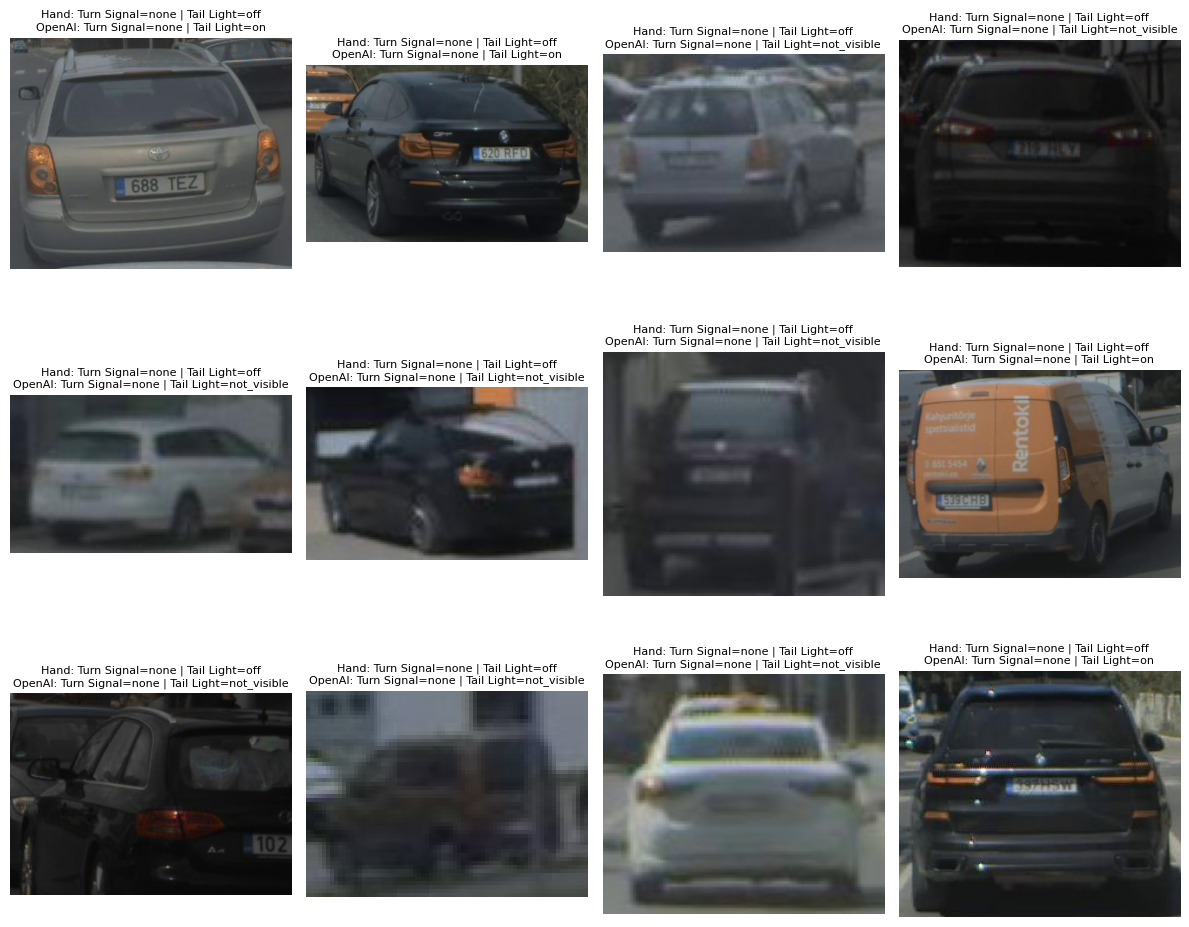

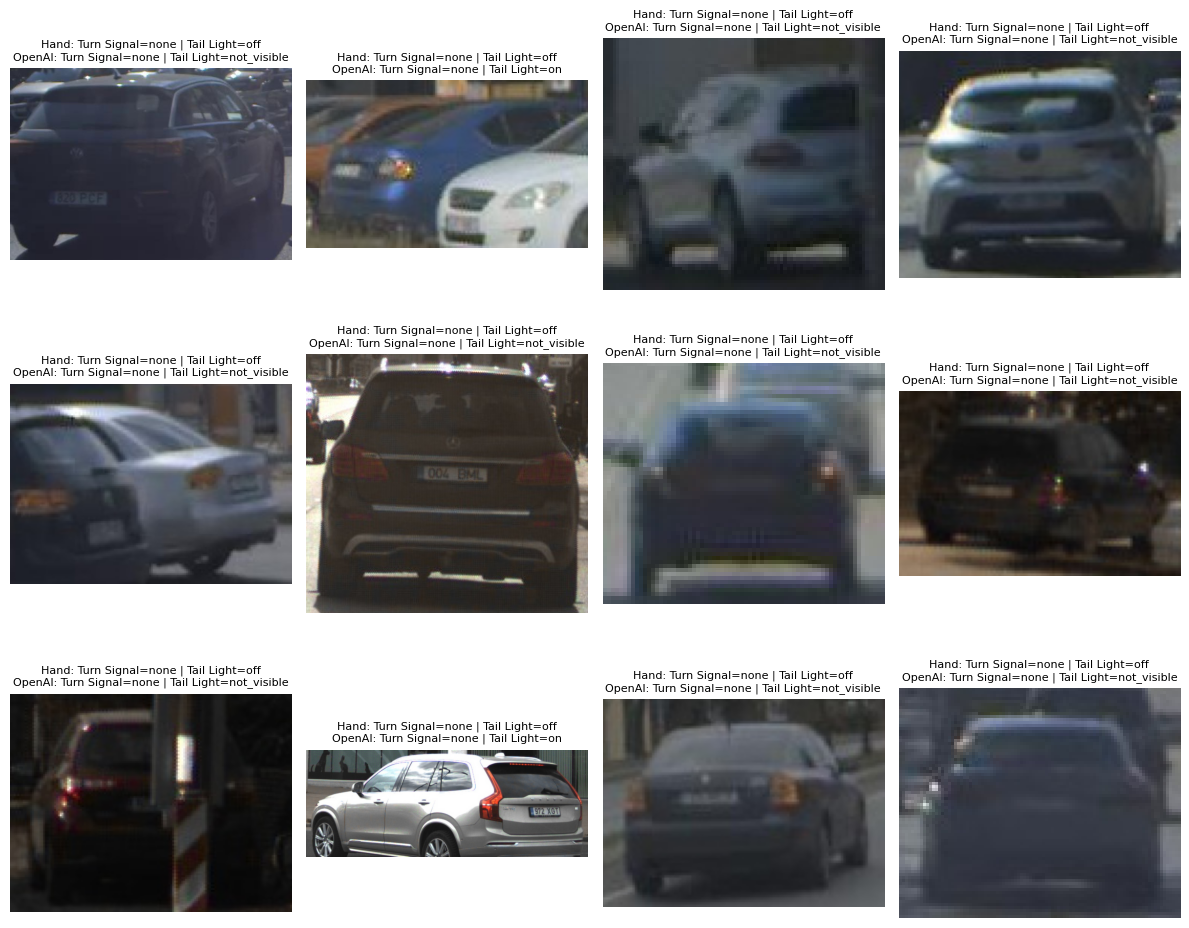

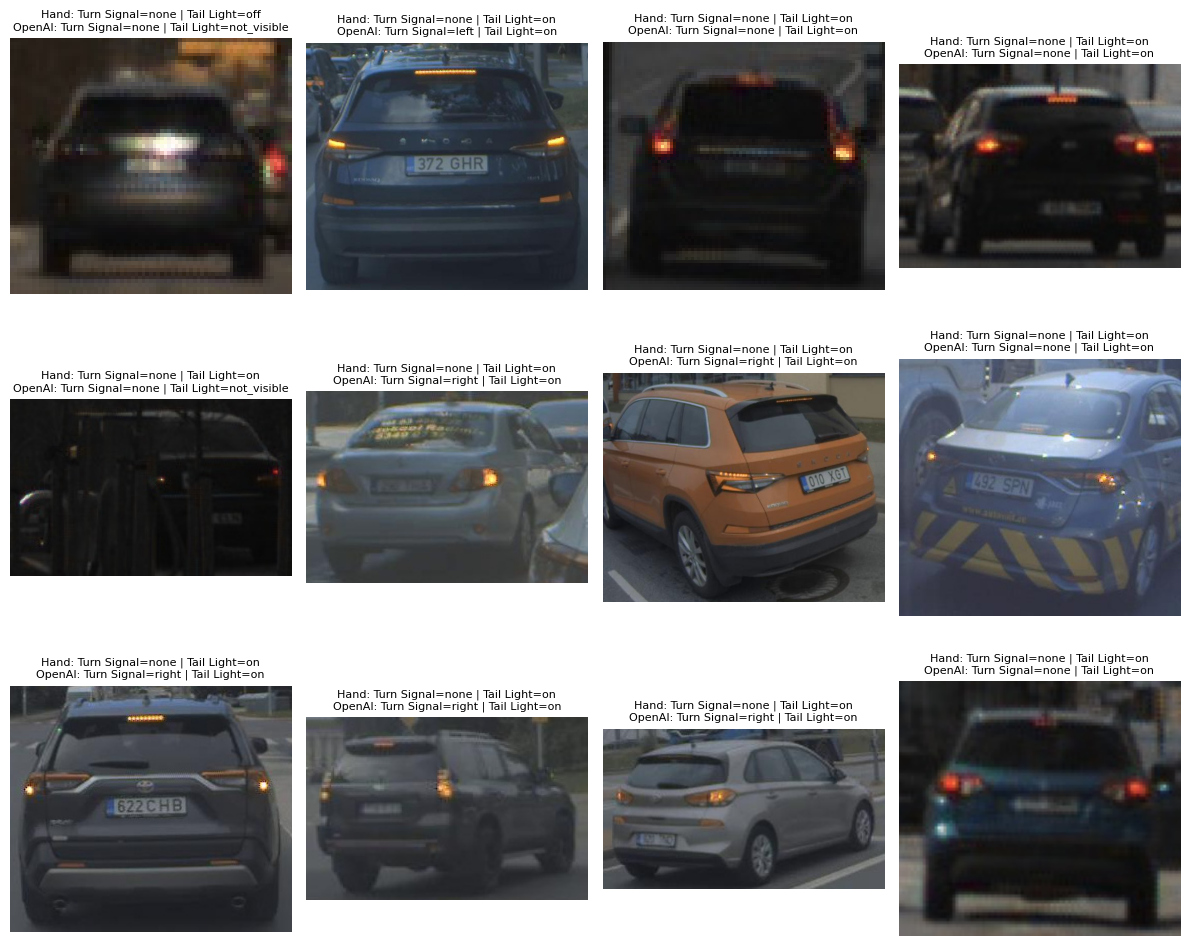

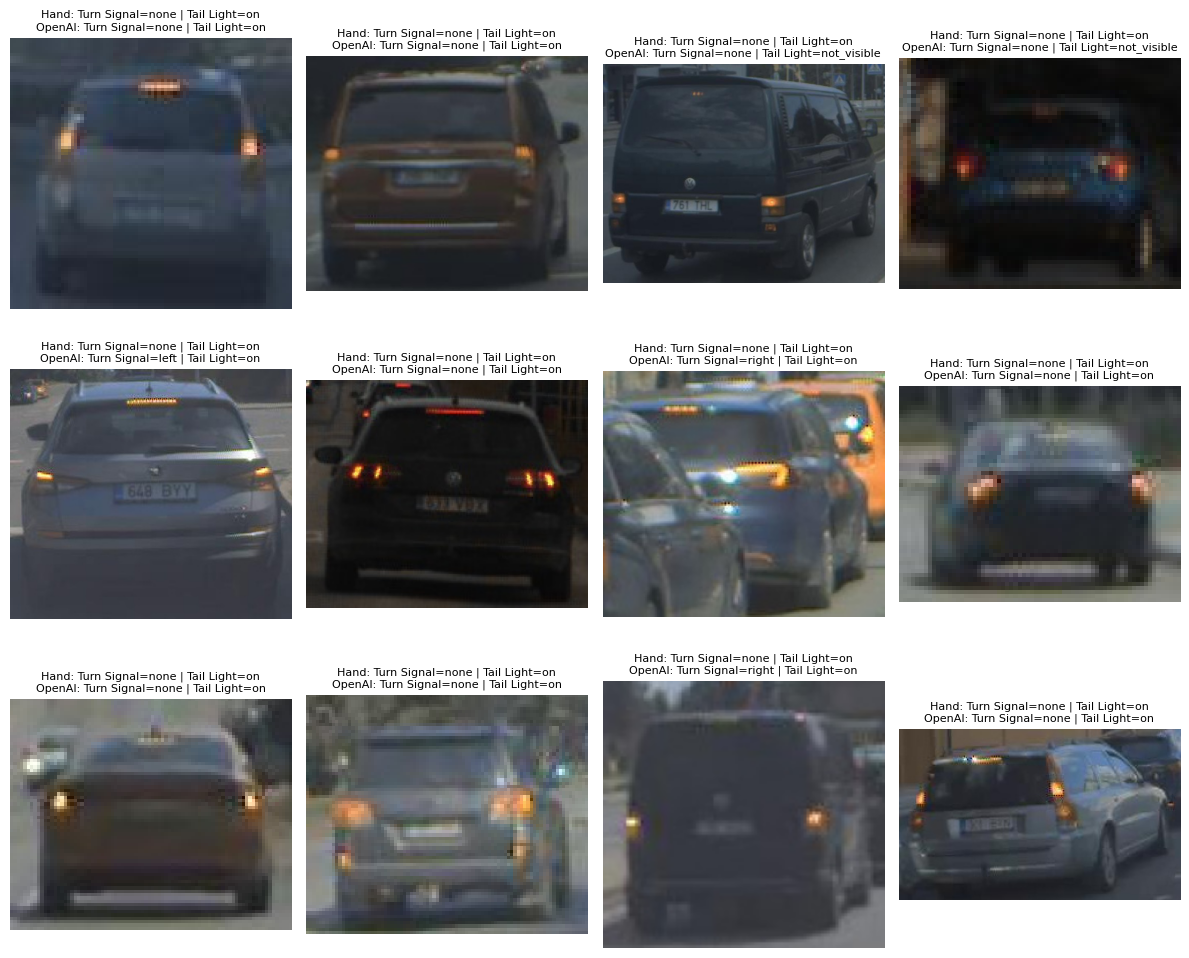

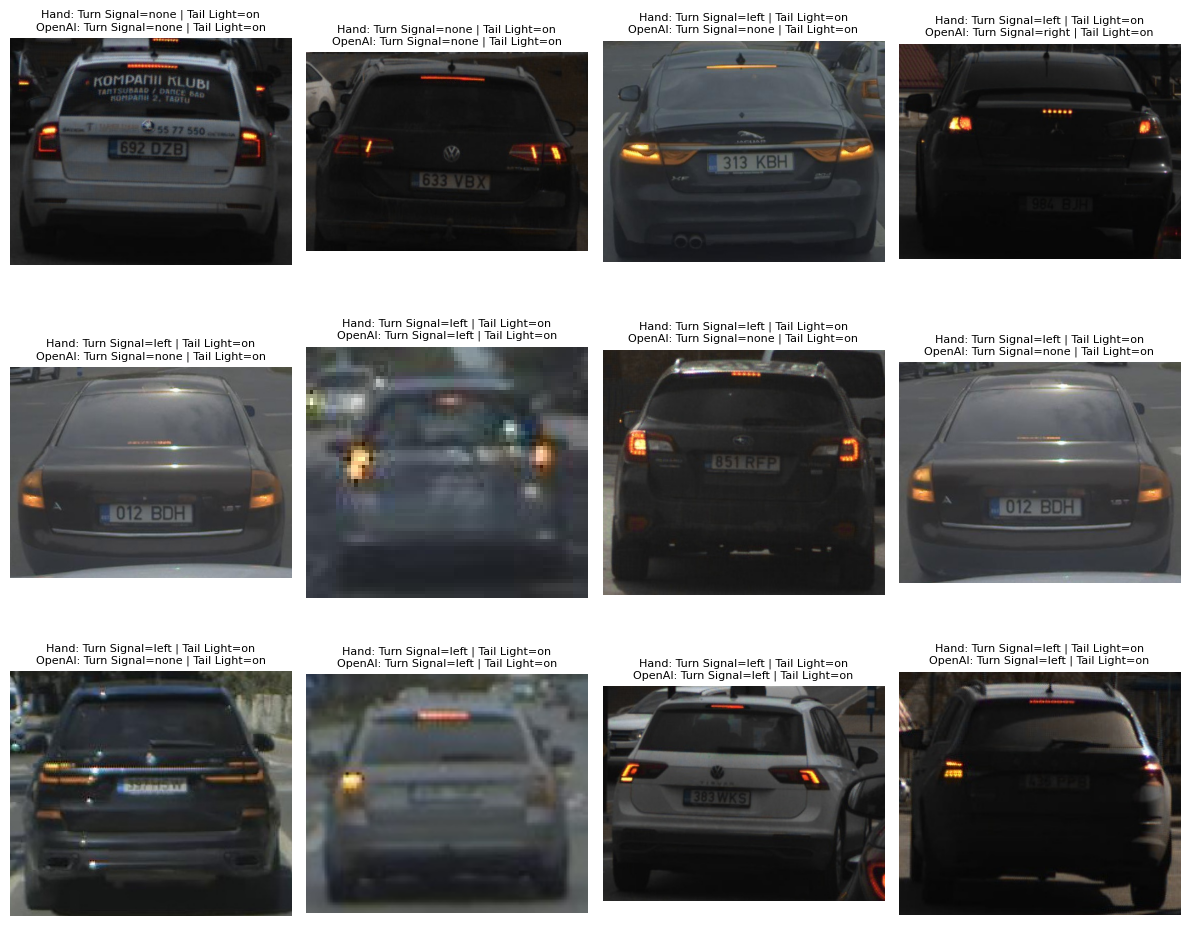

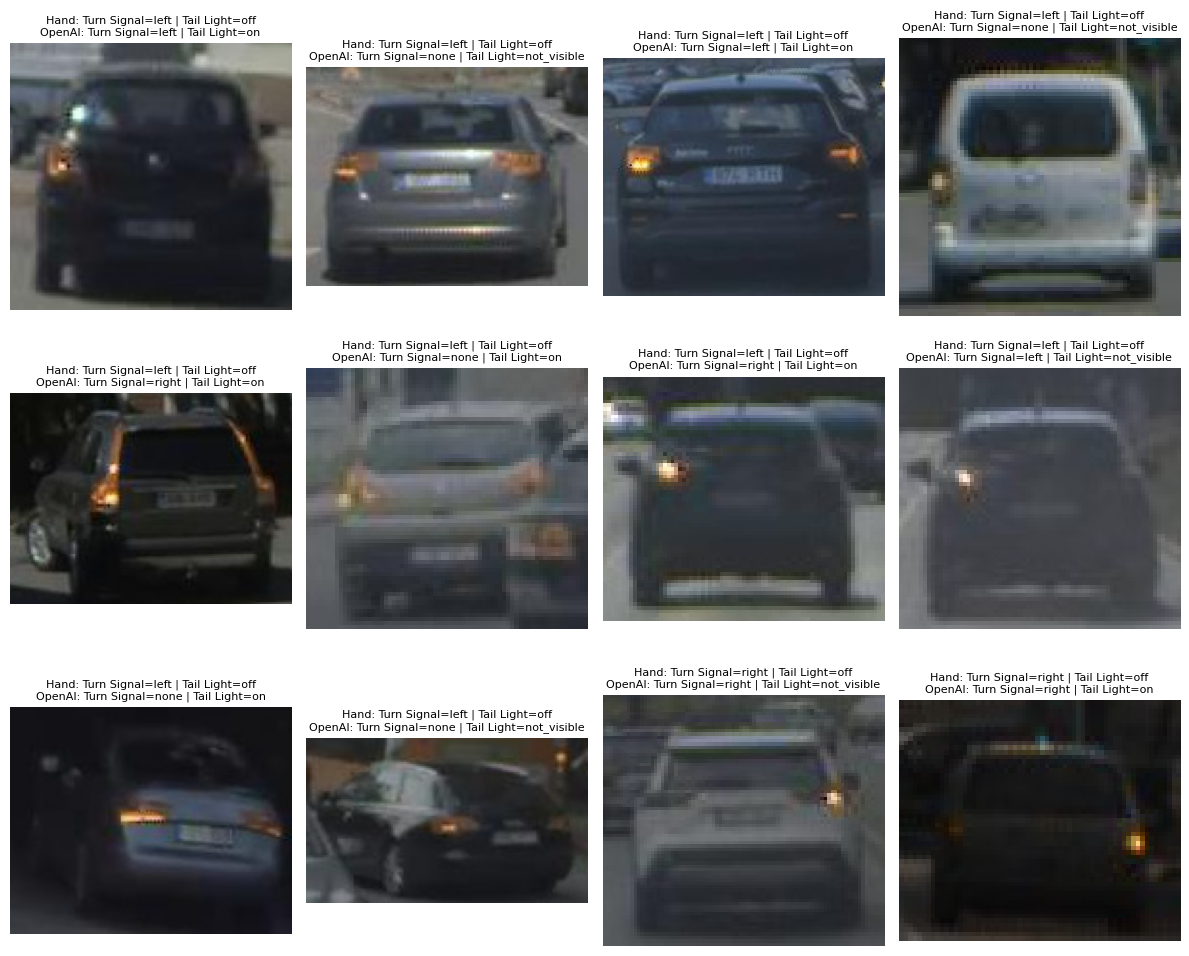

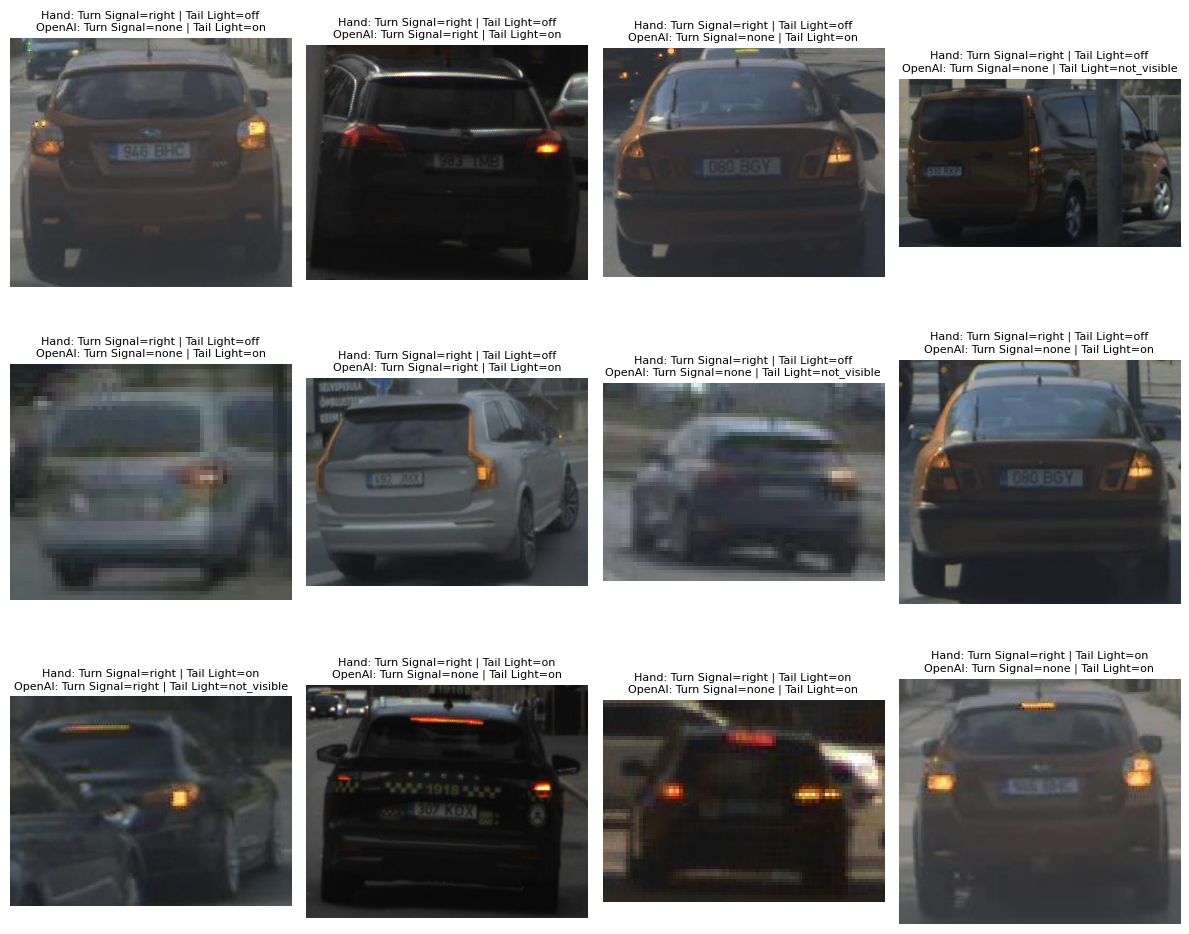

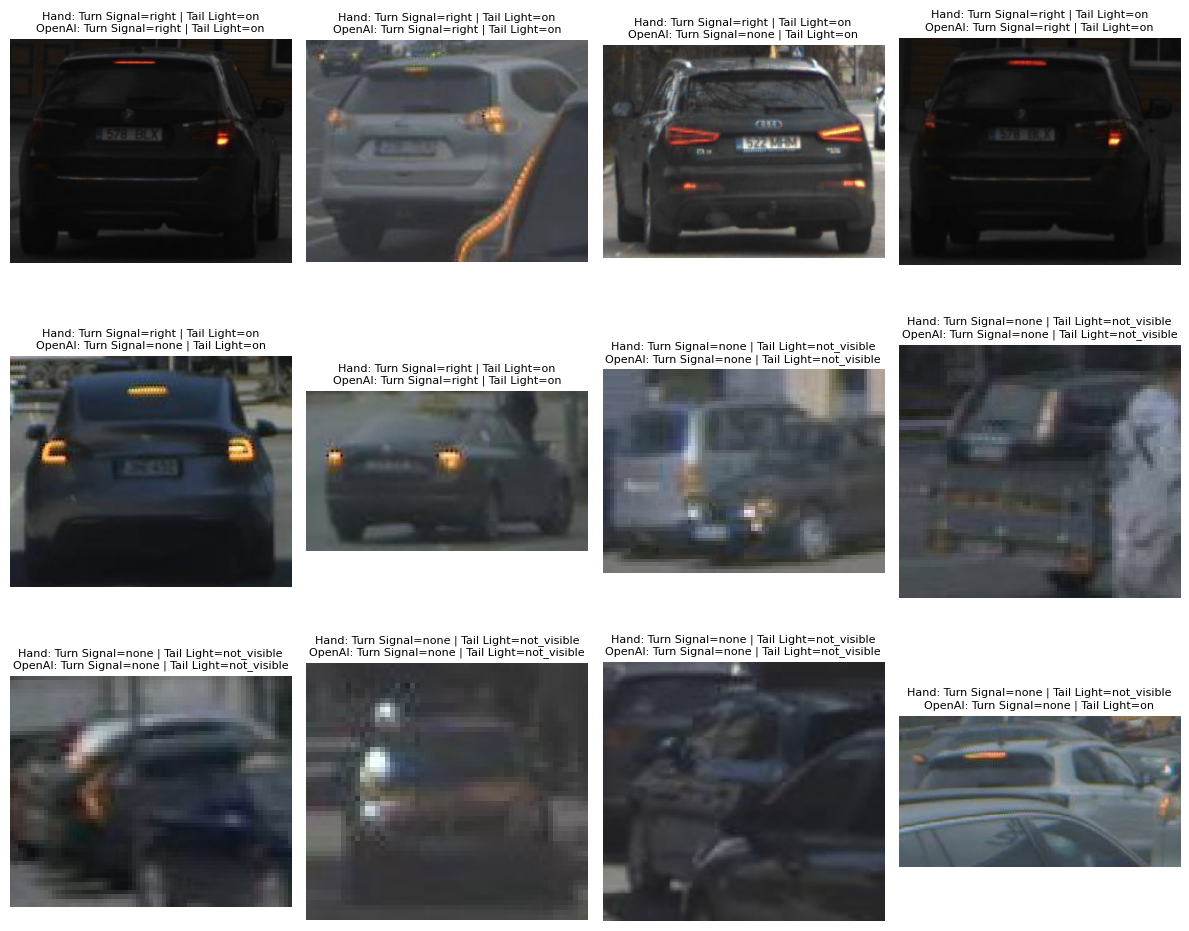

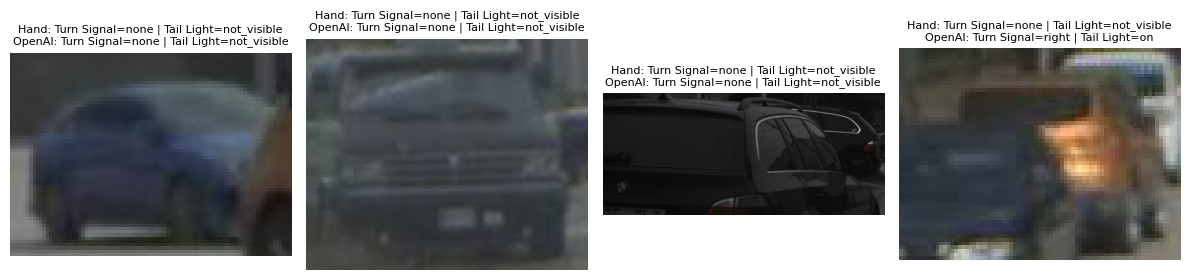

In [9]:
RESULTS_PATH = "openai_light_predictions.json"
LOCAL_BASE = "../sampled_images"

with open(RESULTS_PATH) as f:
    results = json.load(f)

# Display 12 images per page
for i, entry in enumerate(results[:100]):
    if i % 12 == 0:
        plt.figure(figsize=(12, 10))
    plt.subplot(3, 4, (i % 12) + 1)
    img_path = os.path.join(LOCAL_BASE, entry["image"].lstrip("/"))
    try:
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"Hand: Turn Signal={entry['hand_label']['turn_signal']} | Tail Light={entry['hand_label']['tail_light']}\n"
            f"OpenAI: Turn Signal={entry['openai_label']['turn_signal']} | Tail Light={entry['openai_label']['tail_light']}",
            fontsize=8
        )
    except Exception as e:
        plt.title(f"Missing image: {e}")
    if (i + 1) % 12 == 0 or i == len(results) - 1:
        plt.tight_layout()
        plt.show()

## Metrics comparison

In [10]:
with open("openai_light_predictions.json") as f:
    results = json.load(f)

total = len(results)
turn_correct = sum(r["hand_label"]["turn_signal"] == r["openai_label"]["turn_signal"] for r in results)
tail_correct = sum(r["hand_label"]["tail_light"] == r["openai_label"]["tail_light"] for r in results)

print(f"Turn signal accuracy: {turn_correct / total:.2%}")
print(f"Tail light accuracy: {tail_correct / total:.2%}")

Turn signal accuracy: 66.00%
Tail light accuracy: 49.00%
